In [1]:
import pandas as pd
import os
import glob

In [2]:
OUTPUT_FOLDER = 'output.2019.nov.22.16_42_53'
EVENTS_SIZE = 20

In [3]:
def getDatasets(subFolder):
    return {
        os.path.basename(c)[:-4]: pd.read_csv(open(c), skipinitialspace=True)
        for c in glob.glob(os.path.join(OUTPUT_FOLDER, subFolder, '*.csv'))
    }

eventHandled = getDatasets('eventHandled')
eventReceived = getDatasets('eventReceived')
createEvent = getDatasets('createEvent')

retrieveTries = getDatasets('retrieveTries')
retrieveFail = getDatasets('retrieveFail')
retrieveFound = getDatasets('retrieveFound')

dead = pd.read_csv(open(os.path.join(OUTPUT_FOLDER, 'dead.csv')), skipinitialspace=True)

In [4]:
allCreateEvent = pd.concat(createEvent.values())
lastRound = allCreateEvent['round'].max()

consideredEvent = allCreateEvent.query(f'round < {lastRound - 15}')
consideredEvent

,id,timestamp,round
0,130,359.761525,13
1,141,391.682210,15
2,202,570.973020,21
3,235,658.100773,23
4,360,991.669067,35
...,...,...,...
338,20902,56977.229774,1901
339,20941,57083.798650,1904
340,20973,57182.257072,1908
341,20980,57202.800672,1908


In [5]:
nodes = dead['id']

# Delivery ratio

In [6]:
allEventHandled = pd.concat(eventHandled.values(), keys=eventHandled.keys(), names=["receiver"])
allEventHandled

id     timestamp  round
receiver                                                              
9cc8715d-b27b-4784-a465-e1900109a952 0          4     60.015097      4
                                     1          8     90.012925      5
                                     2          1     90.012974      5
                                     3         11     90.013136      5
                                     4          9     90.015250      5
...                                           ...           ...    ...
dcf98b96-82e7-4e30-93d5-3358f17e1e3b 62844  20957  58020.018308   1936
                                     62845  21091  58050.014926   1937
                                     62846  21036  58050.014926   1937
                                     62847  21054  58050.014926   1937
                                     62848  20957  58050.014926   1937

[3685098 rows x 3 columns]

In [7]:
eventsPerRound = allCreateEvent.groupby('round').size().reset_index().set_index('round').rename(columns={0: 'number'})

data = (allEventHandled.groupby(['round', 'receiver', 'id']) \
                       .size() \
                       .groupby(['round', 'receiver']) \
                       .size() \
                       .groupby('round').mean()) \
        .reset_index() \
        .set_index('round') \
        .rename(columns={0: 'deliveries'}) \
        .join(eventsPerRound)
data['deliveryRatio'] = data['deliveries']/EVENTS_SIZE

data = data.reset_index()[['round', 'deliveryRatio']]

In [8]:
allEventHandled.groupby(['round', 'receiver', 'id']).size().reset_index().min()

round                                          3
receiver    000f796d-57d9-4f99-8464-733e2eef6fec
id                                             1
0                                              1
dtype: object

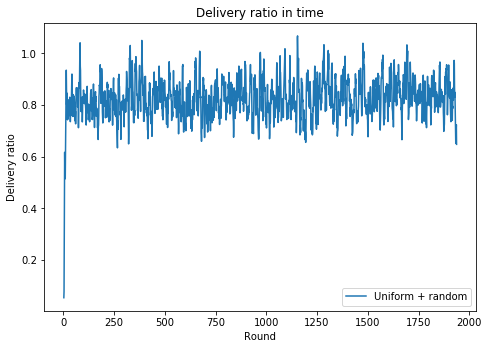

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Delivery ratio in time')
ax.set_xlabel('Round')
ax.set_ylabel('Delivery ratio')

ax.plot(data['round'], data['deliveryRatio'], label='Uniform + random')
ax.legend()
plt.show()

# Redundancy

In [10]:
allEventReceived = pd.concat(eventReceived.values(), keys=eventReceived.keys(), names=["receiver"])
allEventReceived

id     timestamp  round
receiver                                                               
9cc8715d-b27b-4784-a465-e1900109a952 0           4     60.015097      4
                                     1           8     90.012925      5
                                     2           1     90.012974      5
                                     3           4     90.012974      5
                                     4          11     90.013136      5
...                                            ...           ...    ...
dcf98b96-82e7-4e30-93d5-3358f17e1e3b 195700  21247  58050.014926   1937
                                     195701  21036  58050.014926   1937
                                     195702  21054  58050.014926   1937
                                     195703  21091  58050.014926   1937
                                     195704  21249  58050.014926   1937

[11468809 rows x 3 columns]

In [11]:
final = pd.DataFrame(columns=['round', 'redundancy'])#, 'receiver'])

for node in nodes:
    currentEventReceived = eventReceived[node]
    currentEventHandled = eventHandled[node]

    evEh = currentEventHandled.groupby('id').min().reset_index()[['id', 'timestamp']].set_index('id')
    w = currentEventReceived \
        .set_index('id') \
        .join(
            evEh, 
            lsuffix='_received', 
            rsuffix='_handled') \
        .query('timestamp_received > timestamp_handled') \
        .groupby('round') \
        .size() \
        .reset_index() \
        .set_index('round') \
        .join(currentEventReceived.groupby('round').size().reset_index().set_index('round'), lsuffix='_redundant', rsuffix='_total') \
        .reset_index()

    w['redundancy'] = w['0_redundant']/w['0_total']
    w = w[['round', 'redundancy']]
    
    final = pd.concat([final,w])
    
final = final.groupby('round') \
             .mean() \
             .reset_index()

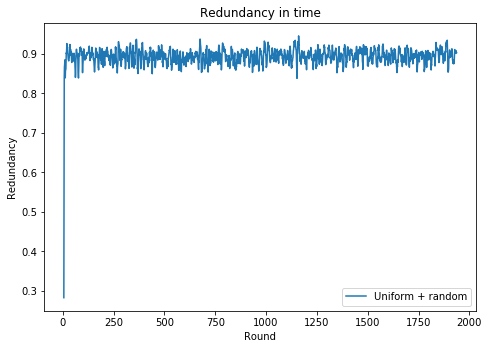

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Redundancy in time')
ax.set_xlabel('Round')
ax.set_ylabel('Redundancy')

ax.plot(final['round'], final['redundancy'], label='Uniform + random')
ax.legend()
plt.show()

# Reliability

In [13]:
aliveForMessageId = allCreateEvent.copy()
aliveForMessageId['nAlive'] = aliveForMessageId.timestamp.apply(lambda t: sum((dead.timestamp < 0) | (dead.timestamp > t)))
aliveForMessageId = aliveForMessageId[aliveForMessageId.id.isin(consideredEvent.id)][['id', 'nAlive']].set_index('id')
aliveForMessageId

,nAlive
id,
130,60
141,60
202,60
235,60
360,60
...,...
20902,60
20941,60
20973,60


In [14]:
w = allEventHandled.groupby(['receiver', 'id']).size().groupby('id').size().reset_index()
w = w[w['id'].isin(list(consideredEvent.id))]
w

,id,0
0,1,60
1,2,60
2,3,60
3,4,60
4,5,60
...,...,...
21112,21113,40
21113,21114,59
21114,21115,50
21115,21116,54


In [15]:
w = w.rename(columns={0: 'handled'}).set_index('id').join(aliveForMessageId)
(w['handled'] / w['nAlive']).mean()

0.7992225852788432

# Throughput

In [16]:
obtainedByAll = allEventHandled.groupby(['receiver', 'id']) \
                               .size() \
                               .groupby('id') \
                               .size() \
                               .reset_index() \
                               .rename(columns={0: 'nObtained'})

obtainedByAll = obtainedByAll[obtainedByAll.id.isin(consideredEvent.id)]

In [17]:
obtainedVsAlive = obtainedByAll.set_index('id').join(aliveForMessageId)
stability = obtainedVsAlive['nObtained'] / obtainedVsAlive['nAlive']
stability

id
1        1.000000
2        1.000000
3        1.000000
4        1.000000
5        1.000000
           ...   
21113    0.666667
21114    0.983333
21115    0.833333
21116    0.900000
21117    0.900000
Length: 21117, dtype: float64

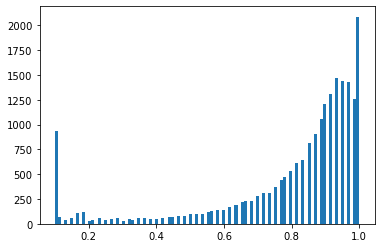

In [18]:
plt.hist(stability, bins=100)
plt.show()

In [19]:
sum( obtainedVsAlive['nObtained'] == obtainedVsAlive['nAlive'] ) / obtainedVsAlive.count()

nObtained    0.098878
nAlive       0.098878
dtype: float64

In [20]:
obtainedVsAlive.query('nObtained == 1')

,nObtained,nAlive
id,,
